In [2]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

Using TensorFlow backend.


0


In [3]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.regularizers import L1L2

In [4]:
train_df = pd.read_csv("./input/train.csv")

print("Train shape : ",train_df.shape)


Train shape :  (1306122, 3)


In [5]:
## Config values 
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2019)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=2020)
print("Validation shape : ",val_df.shape)
print("Test shape : ",test_df.shape)
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
oov_tok = "OOV_TOK"
tokenizer = Tokenizer(num_words=max_features) # lower = False, oov_token=oov_tok)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen, truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post')

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values
test_y = test_df['target'].values

Validation shape :  (130612, 3)
Test shape :  (130613, 3)


In [7]:
EMBEDDING_FILE = './input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [19]:
regularizer = L1L2(l1=0.0, l2=0.001)
del model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, trainable=True, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 128)           187392    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total para

In [20]:
# Define callback function if detailed log required

class History(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_acc = []
        self.val_acc = []
        self.val_loss = []
        for keys in logs:
           print(keys) 

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
    #Store val_acc/loss per batch    
    def on_epoch_end(self, batch, logs={}):    
        self.val_acc.append(logs.get('val_acc'))
        self.val_loss.append(logs.get('val_loss'))
        
# Compute class_weights for imbalanced train set
def compute_class_weight(input_list):

  class_weights = class_weight.compute_class_weight('balanced', 
                                                   np.unique(input_list),  
                                                   input_list)
                                                   
  return(class_weights)                                                   
        
#define callback functions
history = History()
callbacks = [history]        

class_weights = compute_class_weight(train_y)

class_weights[1] *= 10
print(class_weights)

[ 0.53290517 80.97591407]


In [21]:

model.fit(train_X, train_y, 
          batch_size=512, 
          epochs=2, 
          validation_data=(val_X, val_y), 
          class_weight = class_weights,
          callbacks= callbacks)
model.save('./output/model_paragram_emb.h5')

Train on 1044897 samples, validate on 130612 samples
Epoch 1/2
1044897/1044897 [==============================] - 49s 47us/sample - loss: 0.1126 - acc: 0.9555 - val_loss: 0.1041 - val_acc: 0.9586
Epoch 2/2
1044897/1044897 [==============================] - 52s 50us/sample - loss: 0.0924 - acc: 0.9630 - val_loss: 0.1036 - val_acc: 0.9587


In [11]:
#from tensorflow.keras.models import Model, load_model

#model =load_model('./output/model_glove.h5')
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

130612/130612 [==============================] - 1s 11us/sample
F1 score at threshold 0.1 is 0.5951393005334913
F1 score at threshold 0.11 is 0.6042752867570386
F1 score at threshold 0.12 is 0.6127898179876285
F1 score at threshold 0.13 is 0.6203096539162113
F1 score at threshold 0.14 is 0.6267045190114953
F1 score at threshold 0.15 is 0.6325501759726053
F1 score at threshold 0.16 is 0.6372539513235722
F1 score at threshold 0.17 is 0.642165579924916
F1 score at threshold 0.18 is 0.645476034803601
F1 score at threshold 0.19 is 0.647173090686024
F1 score at threshold 0.2 is 0.6489234760051881
F1 score at threshold 0.21 is 0.6517090640964871
F1 score at threshold 0.22 is 0.6527451399273659
F1 score at threshold 0.23 is 0.6551350178939378
F1 score at threshold 0.24 is 0.6585674234511572
F1 score at threshold 0.25 is 0.6600990705181722
F1 score at threshold 0.26 is 0.6606299212598425
F1 score at threshold 0.27 is 0.662119145065939
F1 score at threshold 0.28 is 0.6609145815358067
F1 score at

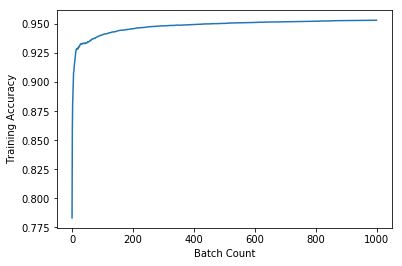

In [22]:
x = range(len(history.train_acc))
%matplotlib inline
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Accuracy')
plt.plot(x[0:1000], history.train_acc[0:1000])
plt.show()
fig.savefig('paragram_emb_accuracy')

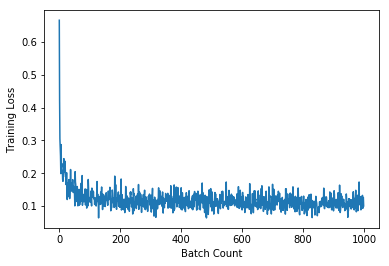

In [23]:
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Loss')
plt.plot(x[0:1000], history.train_loss[0:1000])
plt.show()
fig.savefig('paragram_emb_loss')

In [ ]:

%matplotlib inline
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
#fig.savefig('self_train_emb_F1_score')

In [24]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
f1_max = 0
opt_thresh = 0
test_y = test_df['target'].values
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(test_y, (pred_test_y>thresh).astype(int))
    if(f1_score > f1_max):
        f1_max = f1_score
        opt_thresh = thresh
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

pred = [int(a > opt_thresh) for a in pred_test_y]    

130613/130613 [==============================] - 2s 12us/sample
F1 score at threshold 0.1 is 0.5952874802953622
F1 score at threshold 0.11 is 0.602531002666441
F1 score at threshold 0.12 is 0.6101548682110349
F1 score at threshold 0.13 is 0.6174000967160505
F1 score at threshold 0.14 is 0.6241172789845356
F1 score at threshold 0.15 is 0.6295540129758177
F1 score at threshold 0.16 is 0.634173308149445
F1 score at threshold 0.17 is 0.6386256477288642
F1 score at threshold 0.18 is 0.6425193871760924
F1 score at threshold 0.19 is 0.6457815190357757
F1 score at threshold 0.2 is 0.6497363711120786
F1 score at threshold 0.21 is 0.6517852781712499
F1 score at threshold 0.22 is 0.6551383399209486
F1 score at threshold 0.23 is 0.6580354911272182
F1 score at threshold 0.24 is 0.6608792207136729
F1 score at threshold 0.25 is 0.662787730311846
F1 score at threshold 0.26 is 0.6652218782249741
F1 score at threshold 0.27 is 0.6675351745700886
F1 score at threshold 0.28 is 0.6691586816889544
F1 score a

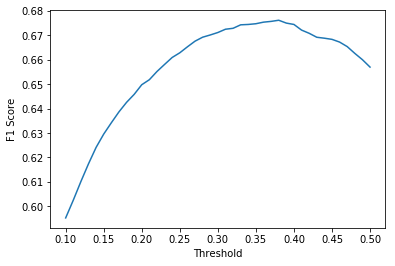

In [25]:
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
fig.savefig('paragram_emb_F1_score')

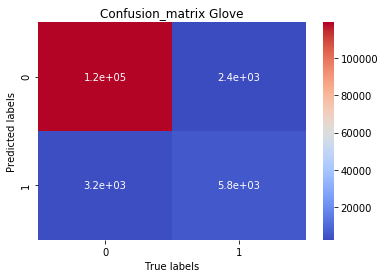

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
import seaborn as sns
def get_confusion_matrix(val_y, pred,title):
    cm=confusion_matrix(pred,val_y)
   
    fig = plt.figure()
    sns.heatmap(cm, cmap='coolwarm', annot=True)
    plt.title(title)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()
    fig.savefig('paragram_confusion_matrix')
 
get_confusion_matrix(test_y,pred,'Confusion_matrix Glove')    

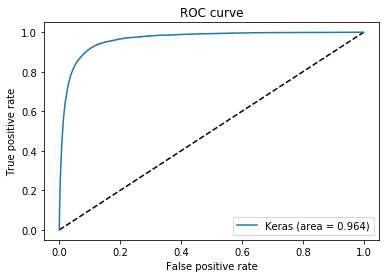

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, pred_test_y)
auc_keras = auc(fpr_keras, tpr_keras)
fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
fig.savefig('paragram_ROC')